In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

/Users/wakaka/Desktop/TB/dsa4263/project/dsa4263-twitter-bot-detection/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
## run this cell only if u use mac, this is for connecting to nltk servers to download certain libs
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

## Cleaning the data

In [2]:
data = pd.read_csv("data/raw/twitter_human_bots_dataset.csv")
# dropping uncessary id columns
data.drop(columns=['Unnamed: 0', 'id'], inplace=True)
# dropping inconsistent rows
data.drop(data[(data['verified'] == True) & (data['account_type'] == 'bot')].index, inplace=True)
# convert to datetime
data['created_at'] = pd.to_datetime(data['created_at'])
data

,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,lang,location,profile_background_image_url,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,2016-10-15 21:32:11,False,False,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,False,en,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/7874121826...,best_in_dumbest,11041,False,7.870,1403,bot
1,2016-11-09 05:01:30,False,False,Photographing the American West since 1980. I ...,536,860,880,False,en,Estados Unidos,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8023296328...,CJRubinPhoto,252,False,0.183,1379,human
2,2017-06-17 05:34:27,False,False,Scruffy looking nerf herder and @twitch broadc...,3307,172,594,True,en,"Los Angeles, CA",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1278890453...,SVGEGENT,1001,False,0.864,1159,human
3,2016-07-21 13:32:25,True,False,Wife.Godmother.Friend.Feline Fanatic! Assistan...,8433,517,633,True,en,"Birmingham, AL",NaN,http://pbs.twimg.com/profile_images/1284884924...,TinkerVHELPK5,1324,False,0.889,1489,human
4,2012-01-15 16:32:35,False,False,Loan coach at @mancity & Aspiring DJ,88,753678,116,True,en,"England, United Kingdom",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9952566258...,JoleonLescott,4202,True,1.339,3138,human
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37433,2009-08-08 13:11:15,True,False,"Role: Stock Taker. Past Roles: Nanny, Sales As...",651,139,1105,False,en,Kingston Upon Hull,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/5844684414...,butchsekab,340,False,0.084,4028,human
37434,2013-01-05 21:35:37,False,False,KINGDOM LANDLORD #FreeCornBread,8839,1121486,605,True,en,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9511349456...,Mathieu_Era,24970,True,8.976,2782,human
37435,2013-01-14 18:05:54,True,False,Bienvenid@s al Twitter Oficial de Sergio Dalma...,399,85630,190,False,it,En constante movimiento,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1174733822...,SDalmaoficial,6174,True,2.226,2773,human
37436,2012-09-10 16:12:02,False,False,Just a good guy wrapped up in a bad system.\nA...,967,138,166,True,en,"Los Angeles, CA",http://abs.twimg.com/images/themes/theme14/bg.gif,http://pbs.twimg.com/profile_images/1265807908...,VinceYearly,982,False,0.339,2899,human


## EDA

In [21]:
numeric_features = [
    'favourites_count',
    'followers_count', 
    'friends_count', 
    'statuses_count', 
    'average_tweets_per_day', 
    'account_age_days'
    ]

boolean_features = [
    'default_profile',
    'default_profile_image',
    'geo_enabled',
    'verified'

]
categorical_features = [
    'lang',
    'location'
]
textual_features = [
    'description',
    'screen_name',
]
image_features = [
    'profile_background_image_url',
    'profile_image_url',
]

### Boolean Features

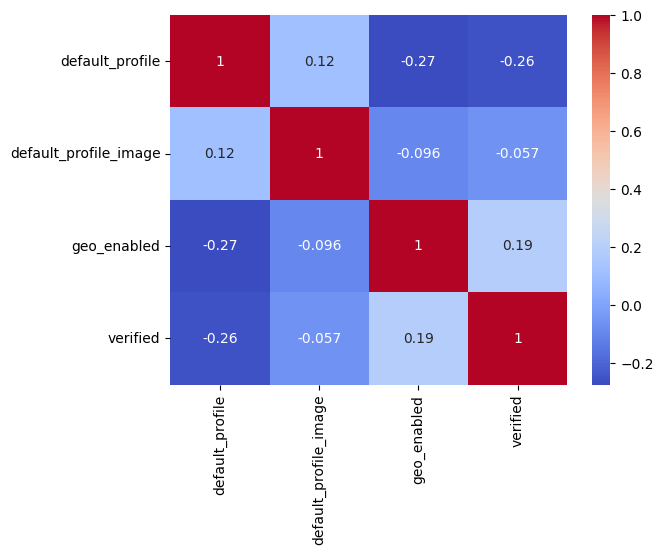

account_type          bot     human
default_profile                    
False            0.204836  0.795164
True             0.491783  0.508217
account_type                bot     human
default_profile_image                    
False                  0.320698  0.679302
True                   0.686380  0.313620
account_type       bot     human
geo_enabled                     
False         0.473923  0.526077
True          0.148927  0.851073
account_type       bot     human
verified                        
False         0.405159  0.594841
True          0.000000  1.000000


In [ ]:
sns.heatmap(data[boolean_features].corr(), annot=True, cmap='coolwarm')
plt.show()
for feature in boolean_features:
    print(pd.crosstab(data[feature], data['account_type'], normalize='index'))

### Textual Features

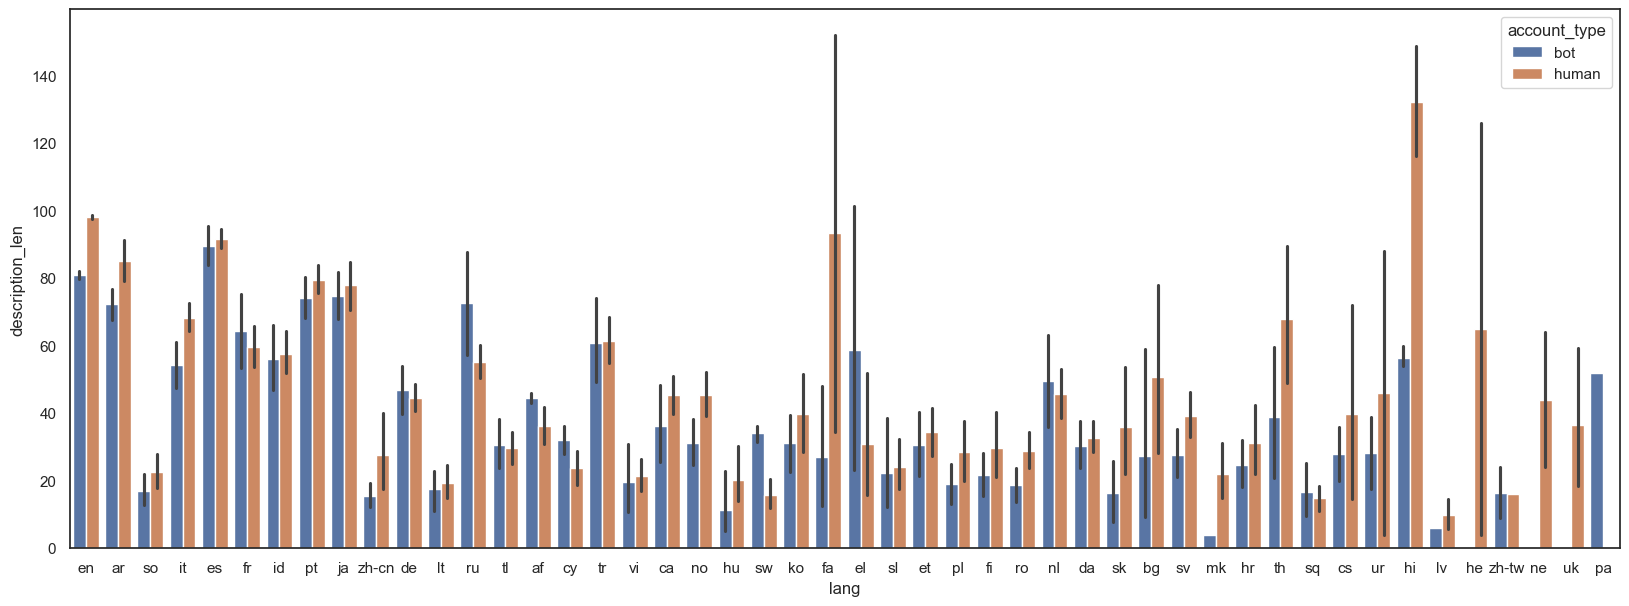

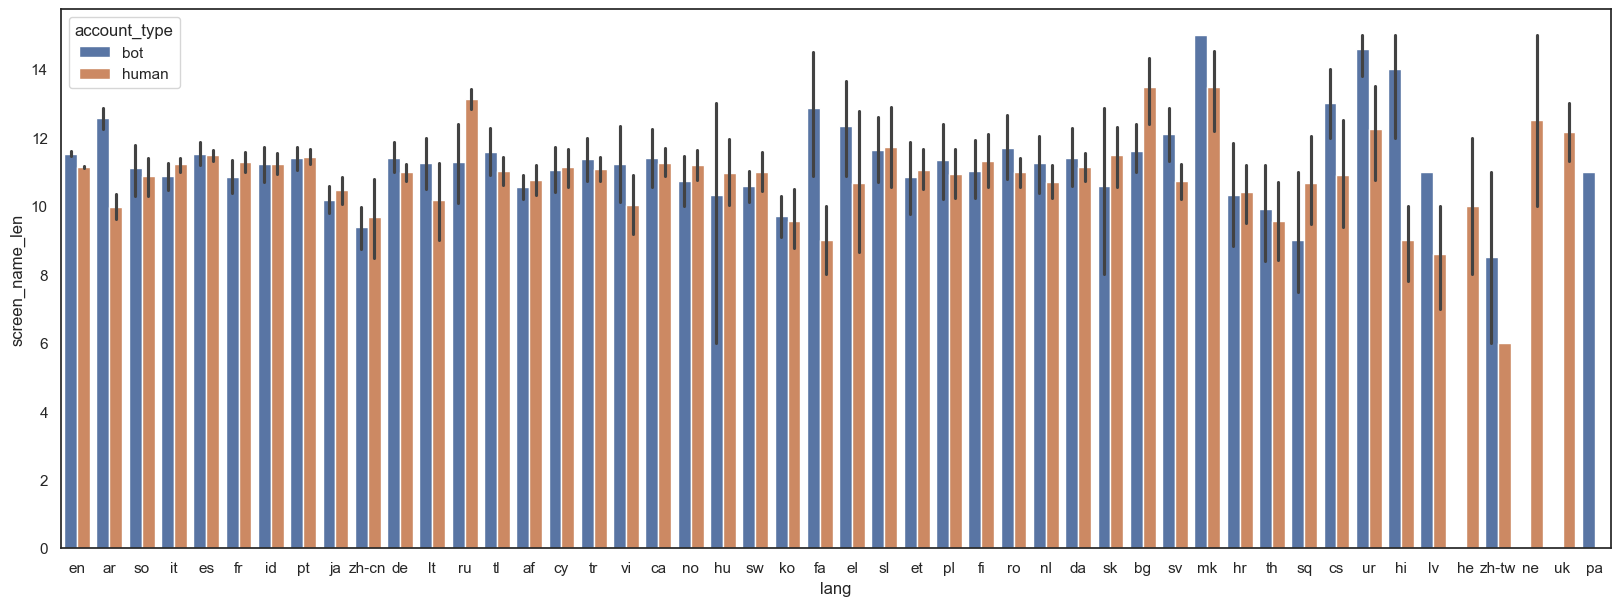

In [ ]:
# Text length
for feature in textual_features:
    data[f'{feature}_len'] = data[feature].str.len()
    plt.figure(figsize=(20, 7))
    sns.barplot(data=data, y=f'{feature}_len', hue='account_type', x='lang', estimator='mean')
    plt.show()

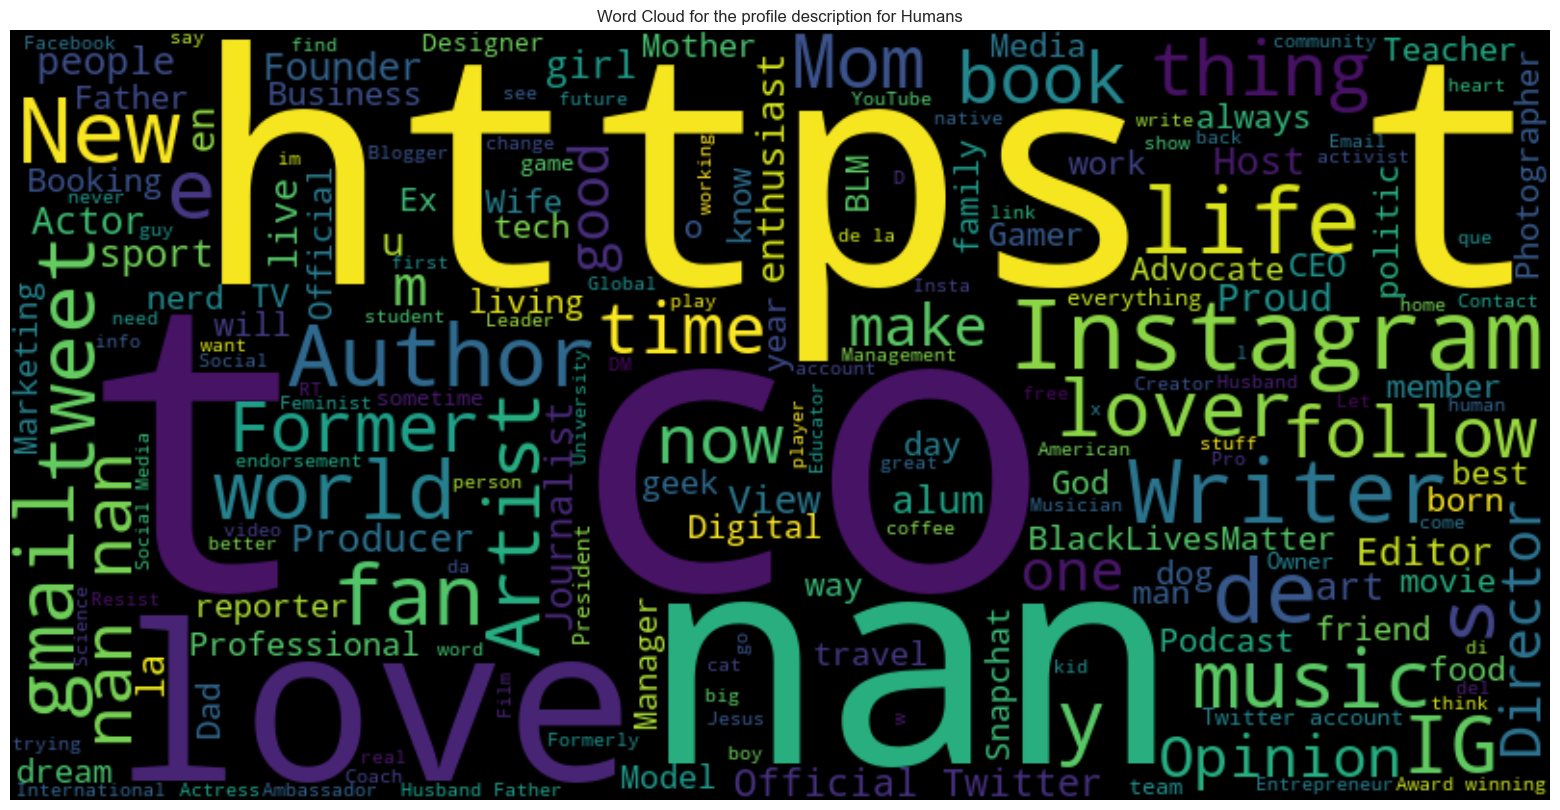

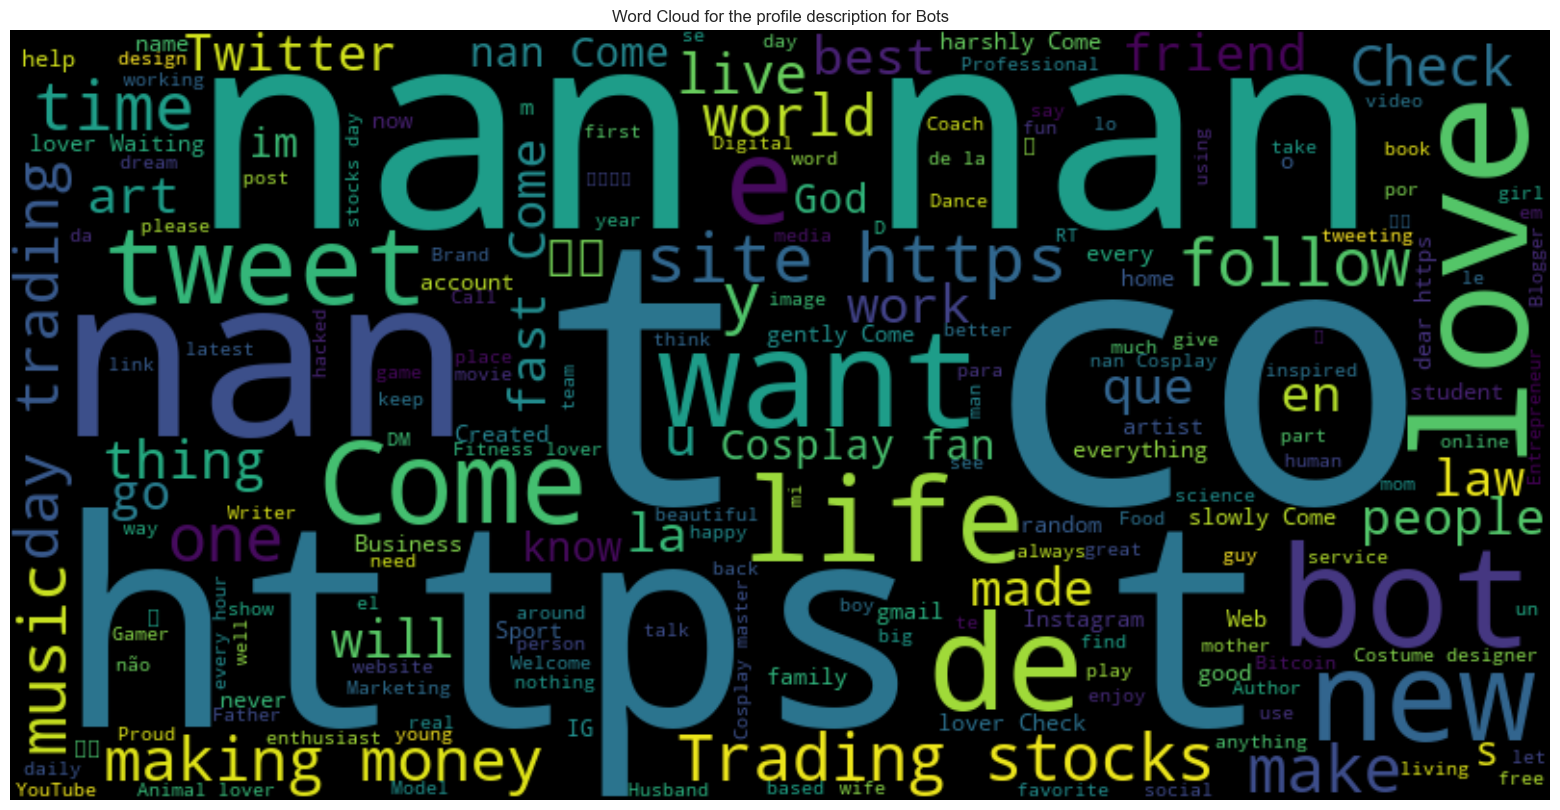

In [ ]:
from wordcloud import WordCloud

wc_human = WordCloud(width=800, height=400).generate(" ".join(data[data['account_type'] == 'human']['description']))
wc_bot = WordCloud(width=800, height=400).generate(" ".join(data[data['account_type'] == 'bot']['description']))

# Display the generated image
plt.figure(figsize=(20, 10))
plt.imshow(wc_human, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for the profile description for Humans')
plt.show()

plt.figure(figsize=(20, 10))
plt.imshow(wc_bot, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for the profile description for Bots')
plt.show()

### Categorical Features

In [ ]:
import re

def find_offenders(df, pattern=r'[$]'):
    offenders = {}
    for col in df.select_dtypes(include=['object', 'string']).columns:
        mask = df[col].astype(str).str.contains(pattern, regex=True, na=False)
        if mask.any():
            offenders[col] = df.loc[mask, col].unique()[:20]  # up to 20 unique offending values
    return offenders

# usage
offending_values = find_offenders(data[categorical_features], r'[$]')   # look for dollar sign
print(offending_values)

{'location': array(['About $ and Family', 'dalla$', 'TEXA$', 'West$ide', '$$$',
       'CashApp is $AuntEs2cents', 'DALLA$, TX', 'Hou$ton', 'HOU$TON',
       'hou$ton, tx', '210.TEXA$', '$crewston, Tx ', 'Dolla$, tx', 'K$A',
       'Making ca$h', 'Bo$$ton', 'BigMoneyTexa$', 'Cℓiƒƒsidє $hαωty •'],
      dtype=object)}


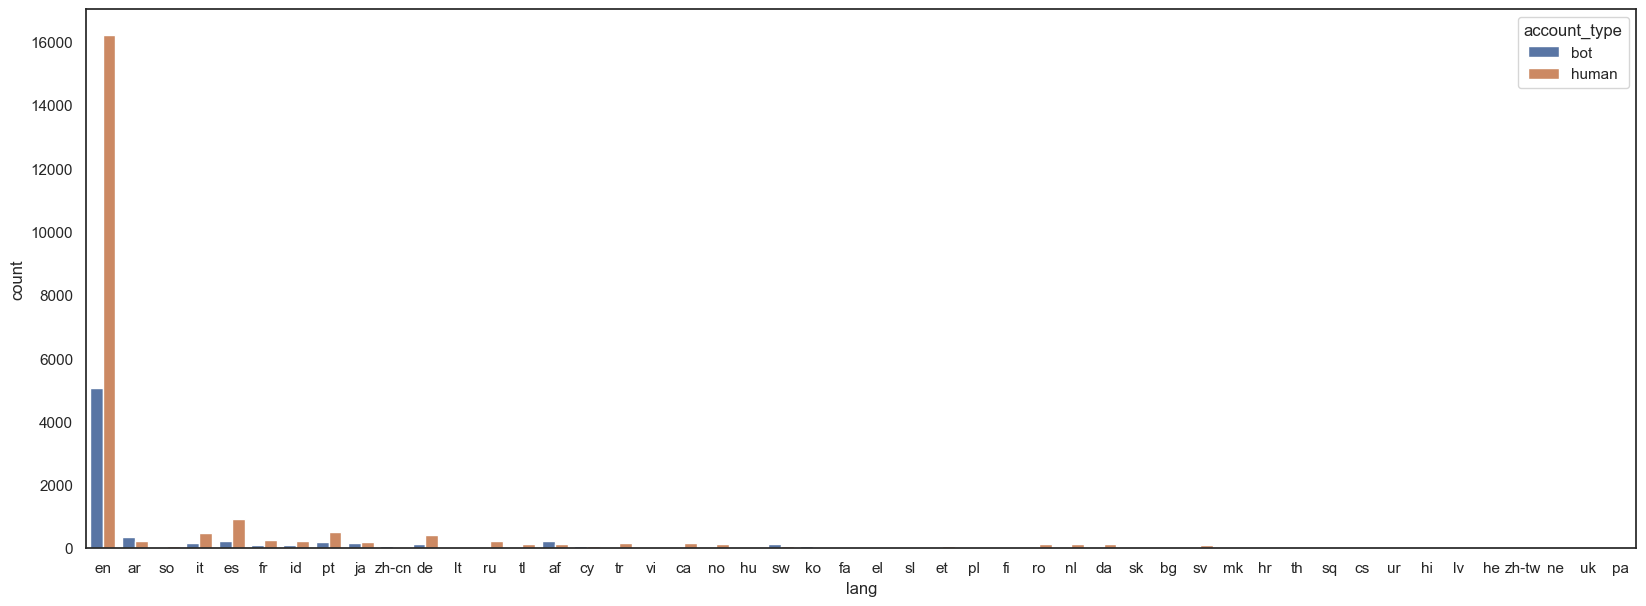

In [137]:
plt.figure(figsize=(20, 7))
sns.countplot(data=data, x='lang', hue='account_type')
plt.show()

### Numeric Features

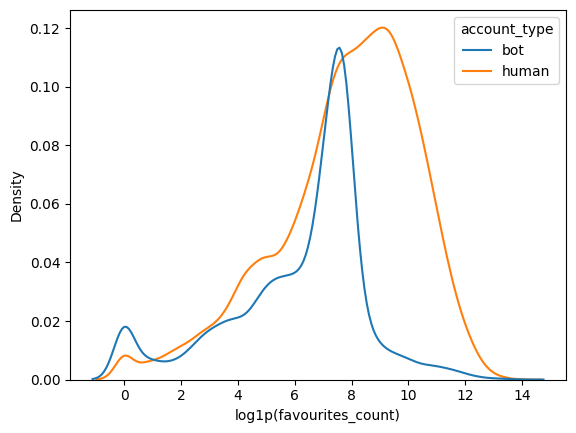

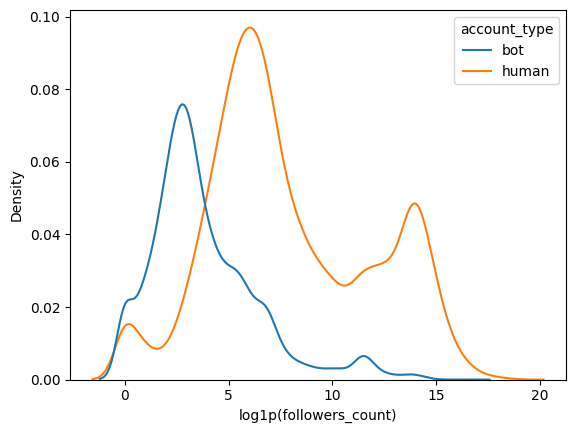

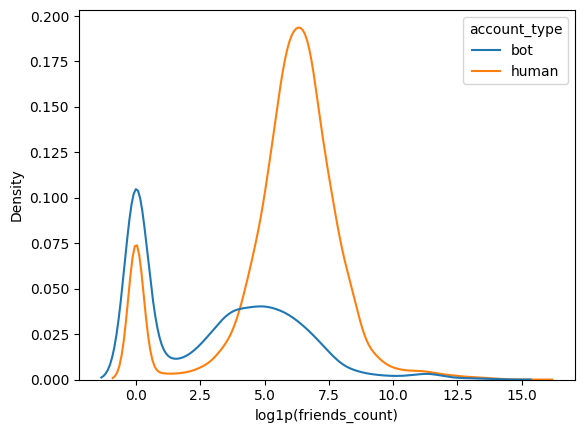

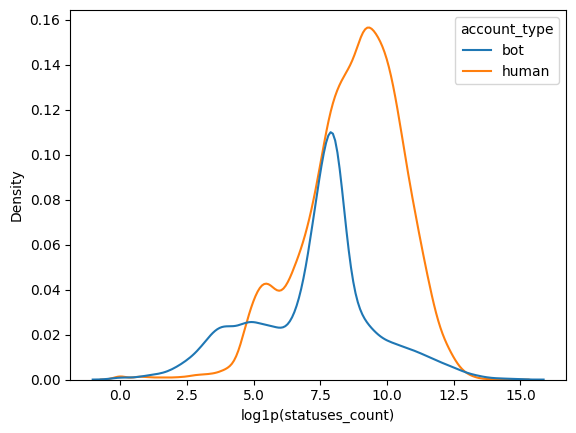

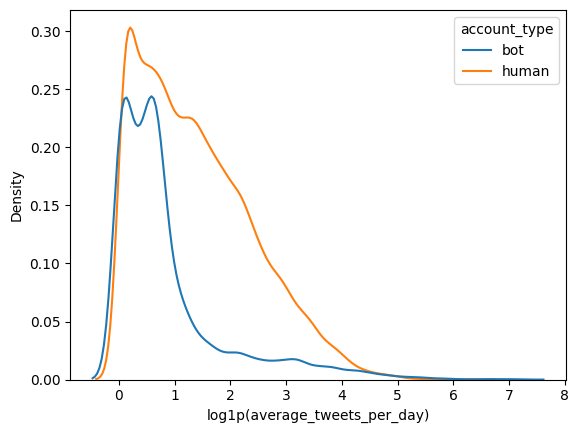

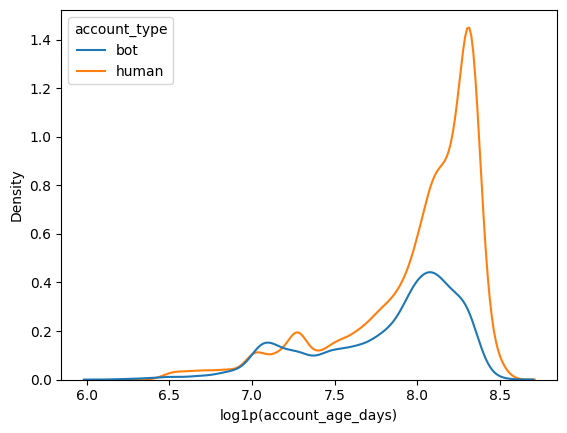

In [41]:
for feature in numeric_features:
    sns.kdeplot(data=data, x=np.log1p(data[feature]), hue='account_type')
    plt.xlabel(f'log1p({feature})')
    # sns.kdeplot(data=data, x=feature, hue='account_type')
    plt.show()

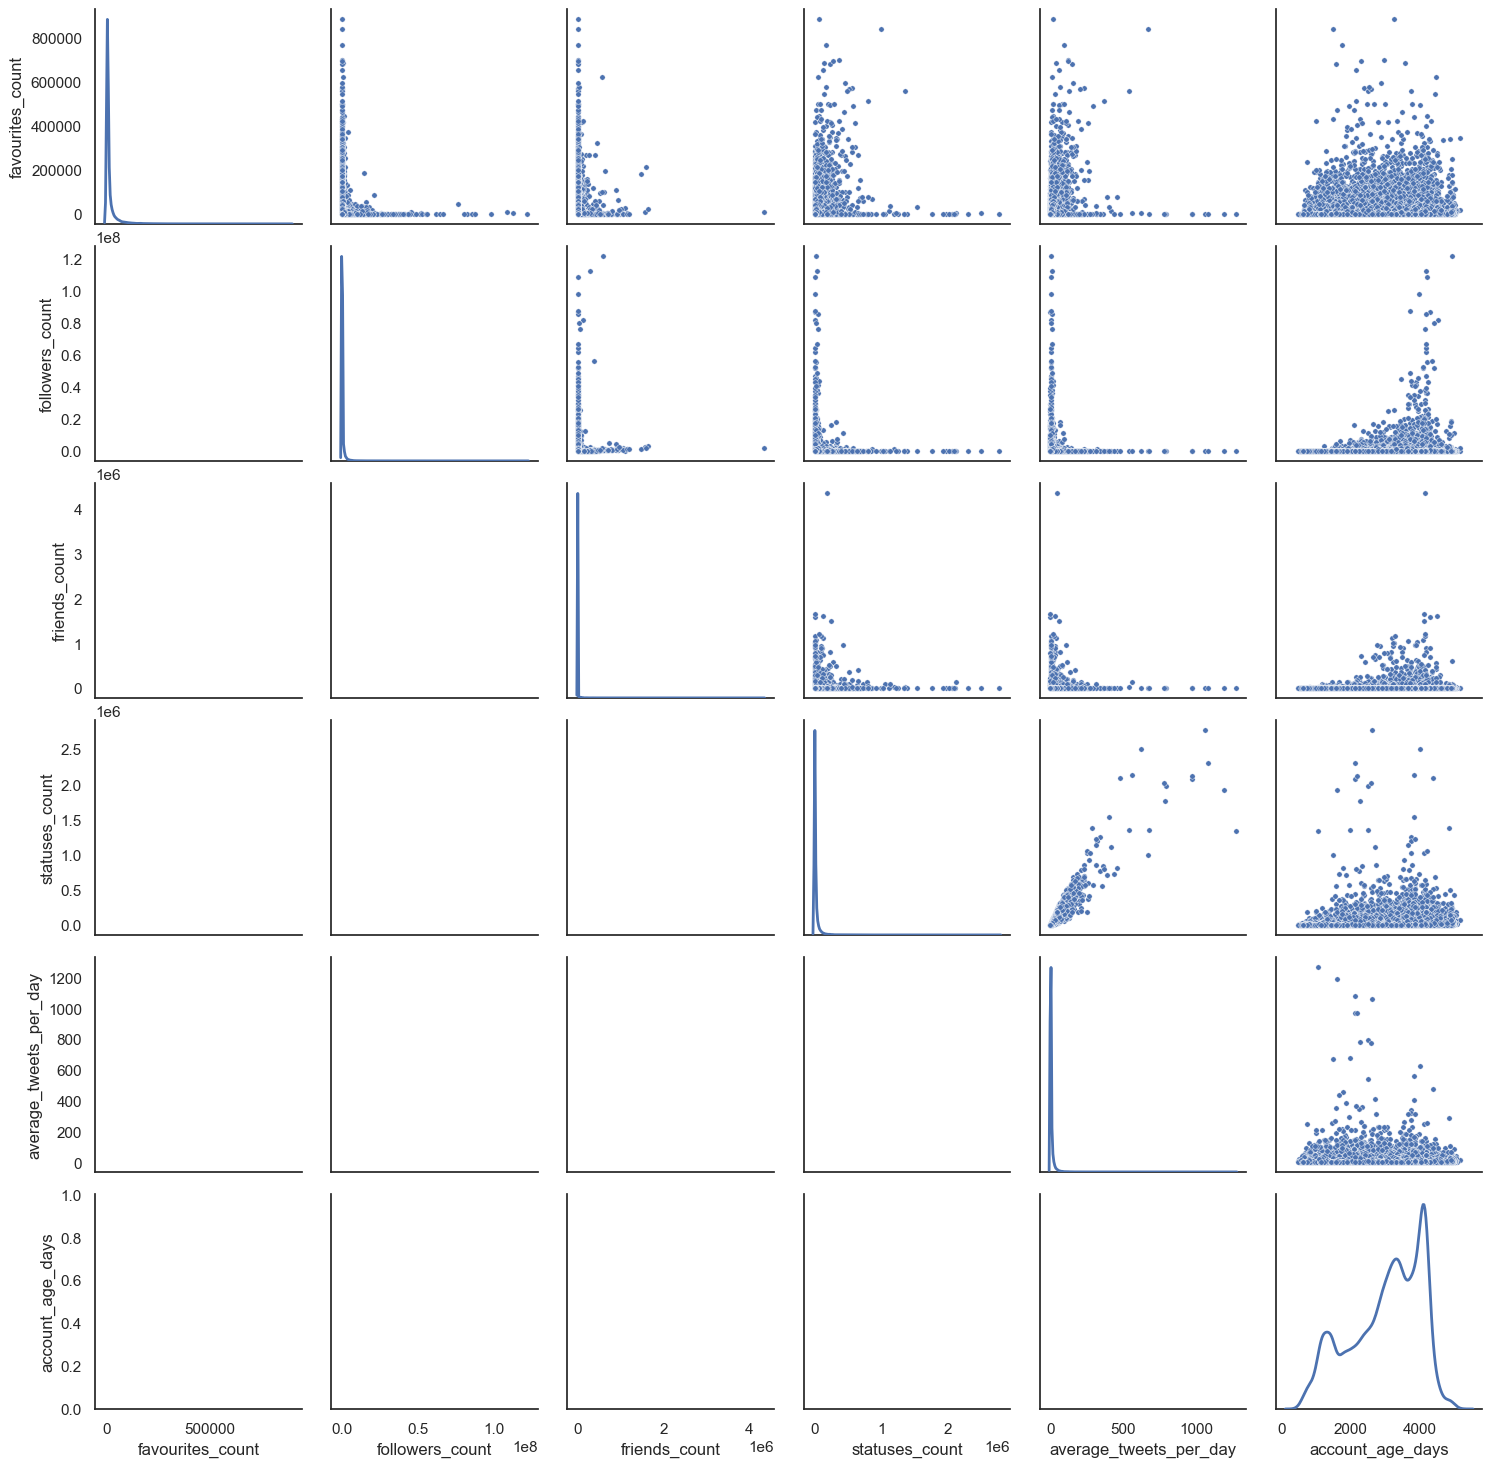

In [69]:
import seaborn as sns
sns.set_theme(style="white")


g = sns.PairGrid(data[numeric_features], diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
# g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

## Training 

[I 2025-10-11 13:23:36,577] A new study created in memory with name: no-name-e299dc75-632d-490b-a5f8-c1eb5ca3e1b6
[I 2025-10-11 13:23:40,246] Trial 0 finished with value: 0.8888780903966533 and parameters: {'learning_rate': 0.15740186889605864, 'max_depth': 2, 'subsample': 0.5868451774718169, 'colsample_bytree': 0.9778375441310837, 'reg_lambda': 1.8150308913329574, 'reg_alpha': 2.89429275937634, 'spw_mult': 1.1767210327542452}. Best is trial 0 with value: 0.8888780903966533.
[I 2025-10-11 13:23:43,579] Trial 1 finished with value: 0.8179509672656803 and parameters: {'learning_rate': 0.004655158469788038, 'max_depth': 2, 'subsample': 0.9958243779147097, 'colsample_bytree': 0.5101325199649807, 'reg_lambda': 0.07276954741327034, 'reg_alpha': 6.337067982176339, 'spw_mult': 0.8928220675975258}. Best is trial 0 with value: 0.8888780903966533.
[I 2025-10-11 13:23:49,965] Trial 2 finished with value: 0.8909231426730196 and parameters: {'learning_rate': 0.005723048831626637, 'max_depth': 5, 'su

Best trial:
  Mean CV AP: 0.9042
    learning_rate: 0.019287234933827276
    max_depth: 8
    subsample: 0.819431351330386
    colsample_bytree: 0.6681078785135239
    reg_lambda: 0.8937874308040801
    reg_alpha: 0.0033832423455426356
    spw_mult: 1.5338870208523023

Validation metrics:
  Average Precision (AP): 0.9027
  ROC-AUC: 0.9374
  Best threshold: 0.5912, F1=0.8128

Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.9198    0.8755    0.8971      5003
           1     0.7661    0.8423    0.8024      2422

    accuracy                         0.8646      7425
   macro avg     0.8429    0.8589    0.8497      7425
weighted avg     0.8696    0.8646    0.8662      7425



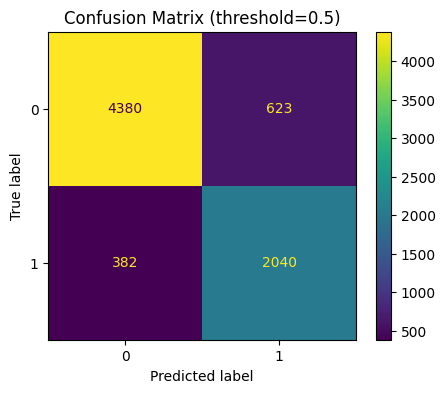


Classification report (optimal threshold):
              precision    recall  f1-score   support

           0     0.9094    0.9093    0.9093      5003
           1     0.8126    0.8130    0.8128      2422

    accuracy                         0.8778      7425
   macro avg     0.8610    0.8611    0.8611      7425
weighted avg     0.8779    0.8778    0.8779      7425



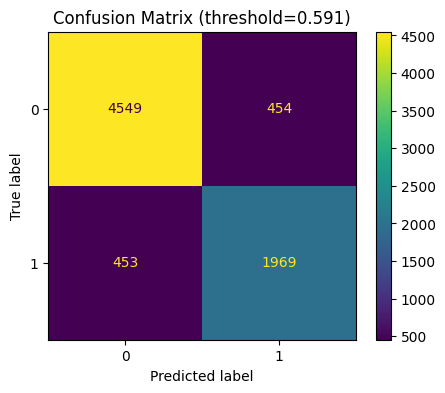

In [16]:
import optuna
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier, callback
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    precision_recall_curve,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

X = data.loc[:, numeric_features]
y = data['account_type'].map(lambda x: 1 if x == 'bot' else 0)

# -------------------------
# Split data
# -------------------------
X_train_full, X_valid, y_train_full, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -------------------------
# Optuna objective
# -------------------------
def objective(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "tree_method": "hist",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
    }

    spw_mult = trial.suggest_float("spw_mult", 0.5, 2.0)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    ap_scores = []

    for tr_idx, va_idx in skf.split(X_train_full, y_train_full):
        X_tr, X_va = X_train_full.iloc[tr_idx], X_train_full.iloc[va_idx]
        y_tr, y_va = y_train_full.iloc[tr_idx], y_train_full.iloc[va_idx]

        n_pos = np.sum(y_tr == 1)
        n_neg = np.sum(y_tr == 0)
        params["scale_pos_weight"] = (n_neg / n_pos) * spw_mult

        clf = XGBClassifier(
            **params,
            n_estimators=1000,
            random_state=42,
            verbosity=0,
        )

        clf.fit(
            X_tr,
            y_tr,
            eval_set=[(X_va, y_va)],
            # callbacks=[callback.EarlyStopping(rounds=50, save_best=True, maximize=False)],
            verbose=False,
        )

        preds = clf.predict_proba(X_va)[:, 1]
        ap = average_precision_score(y_va, preds)
        ap_scores.append(ap)

    return np.mean(ap_scores)

# -------------------------
# Run Optuna study
# -------------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40, n_jobs=1)

print("Best trial:")
print(f"  Mean CV AP: {study.best_value:.4f}")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# -------------------------
# Refit best model
# -------------------------
best_params = study.best_params.copy()
spw_mult = best_params.pop("spw_mult")

n_pos_full = np.sum(y_train_full == 1)
n_neg_full = np.sum(y_train_full == 0)
best_params["scale_pos_weight"] = (n_neg_full / n_pos_full) * spw_mult

model = XGBClassifier(
    **best_params,
    n_estimators=1000,
    random_state=42,
    verbosity=0,
    objective="binary:logistic",
    eval_metric="logloss",
)

model.fit(
    X_train_full,
    y_train_full,
    eval_set=[(X_valid, y_valid)],
    # callbacks=[callback.EarlyStopping(rounds=50, save_best=True, maximize=False)],
    verbose=False,
)

probs = model.predict_proba(X_valid)[:, 1]

# -------------------------
# Find best F1 threshold
# -------------------------
prec, rec, thresholds = precision_recall_curve(y_valid, probs)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-12)
f1_scores = f1_scores[:-1]
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print("\nValidation metrics:")
print(f"  Average Precision (AP): {average_precision_score(y_valid, probs):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_valid, probs):.4f}")
print(f"  Best threshold: {best_threshold:.4f}, F1={best_f1:.4f}")

# -------------------------
# Confusion matrices
# -------------------------
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(5, 4))
    disp.plot(ax=ax, values_format='d')
    ax.set_title(title)
    plt.show()

# Default (0.5)
y_pred_default = (probs >= 0.5).astype(int)
print("\nClassification report (threshold=0.5):")
print(classification_report(y_valid, y_pred_default, digits=4))
plot_cm(y_valid, y_pred_default, "Confusion Matrix (threshold=0.5)")

# Optimal
y_pred_opt = (probs >= best_threshold).astype(int)
print("\nClassification report (optimal threshold):")
print(classification_report(y_valid, y_pred_opt, digits=4))
plot_cm(y_valid, y_pred_opt, f"Confusion Matrix (threshold={best_threshold:.3f})")



In [19]:
model.save_model("model_v1_jh.bin")

/Users/wakaka/Desktop/TB/dsa4263/project/dsa4263-twitter-bot-detection/.venv/lib/python3.10/site-packages/xgboost/sklearn.py:1028: UserWarning: [14:04:57] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
